- 삼성전자 주식 다음달 가격은 어떻게 될까?
- 비트코인 다음달 가격은 어떻게 될까?
- 전날 비트코인 상승하면 다음날 주가와의 상관관계는 어떻게 되는가?

1. 목표설정
    - Y : 미래 30일의 하루간격 주식과 비트코인 종가
    - X : 최근 60일의 하루간격 데이터 (201806 - 201906)
2. 데이터 획득
    - 국내 기업, 비트 코인
3. 데이터 정제
    - 누락제외
4. 데이터 전처리(주의 -> 삼성전자 주식 분할)
    - 특수기호 변환, 문자형을 숫자형으로 변환
    - 날짜 포맷을 YYYY-MM-DD 형식으로 변환한 후에 두 데이터 날짜 기준으로 통합(axis=1) (주의 -> 외국 '-'사용/ 국내 '.' 사용)
    - 결과 : 비트코인 가격 변화와 주가와의 상관관계 표현
5. 입력X / 출력Y 분리
    - m개의 x, y 쌍
    - X : (m, 60, 10-15) -> ridge는 2차원으로만 학습 가능해서 reshape 필요 -> reshape(m, 60*15)
    - Y : (m, 30, 1)
6. 학습용 / 검증용 분리
    - 섞으면 안되므로 직접 분리
    - 가장 오래된 데이터 10%를 검증용으로 사용
7. 모델 선정 
    - Ridge 모델기준으로 학습용 데이터로 학습 
    - 성능 측정
8. 그래프로 시각화
    - 과거
    - 미래의 예측 predict(x(1, 60*15)) > return > y_hat(1, 30*2)
        - 미래 예측 (1, 30*2) > (30, 2) > 국내(30), 비트코인(30) > 그래프로 그리기

2. 데이터 획득

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [187]:
samsung_url='https://finance.naver.com/item/sise_day.nhn?code=005930'

In [188]:
# 삼성 - 28page의 약 일년치 읽어들이기
samsungs = []
for i in range(1, 28):
    tables = pd.read_html(samsung_url+'&page='+str(i))
    samsung = tables[0]
    samsungs.append(samsung)
len(samsungs)

27

In [189]:
# 삼성 - 페이지별 데이터 통합
samsung = pd.concat(samsungs, axis=0)
samsung.shape

(405, 7)

In [190]:
samsung.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
10,2018.05.31,50700.0,1200.0,50400.0,50800.0,49850.0,63491109.0
11,2018.05.30,49500.0,1800.0,51300.0,51500.0,49100.0,20498098.0
12,2018.05.29,51300.0,1000.0,52200.0,52500.0,51300.0,8480437.0
13,2018.05.28,52300.0,400.0,52500.0,53000.0,52000.0,9787820.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
# 비트코인 - 
bitcoin_url = 'https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20180601&end=20190601'
tables = pd.read_html(bitcoin_url)
bitcoin = tables[0]
len(tables)

2

In [192]:
tables

[             Date    Open*     High      Low  Close**       Volume  \
 0    Jun 01, 2019  8573.84  8625.60  8481.58  8564.02  22488303544   
 1    May 31, 2019  8320.29  8586.66  8172.55  8574.50  25365190957   
 2    May 30, 2019  8661.76  9008.31  8221.27  8319.47  29246528551   
 3    May 29, 2019  8718.59  8755.85  8482.73  8659.49  23473479966   
 4    May 28, 2019  8802.76  8807.02  8634.72  8719.96  24226919267   
 5    May 27, 2019  8674.07  8907.17  8668.70  8805.78  27949839564   
 6    May 26, 2019  8055.21  8687.52  7924.67  8673.22  26677970091   
 7    May 25, 2019  7991.89  8117.93  7965.98  8052.54  22256813107   
 8    May 24, 2019  7881.70  8140.72  7824.45  7987.37  25919126991   
 9    May 23, 2019  7677.27  7943.79  7533.20  7881.85  24457107820   
 10   May 22, 2019  7956.29  7997.61  7615.99  7680.07  24719473175   
 11   May 21, 2019  7977.97  8062.17  7843.34  7963.33  25127245056   
 12   May 20, 2019  8196.92  8200.97  7678.78  7978.31  23843404340   
 13   

3. 데이터 정제

날짜 포맷을 YYYY-MM-DD 형식으로 변환

두 데이터 날짜 기준으로 통합(axis=1) (주의 -> 외국 '-'사용/ 국내 '.' 사용)

In [193]:
samsung.shape, bitcoin.shape

((405, 7), (366, 7))

In [194]:
# 날짜를 인덱스로
samsung = samsung.set_index('날짜')
bitcoin = bitcoin.set_index('Date')

In [195]:
# index 타입 obejct -> date
samsung.index = pd.to_datetime(samsung.index)
bitcoin.index = pd.to_datetime(bitcoin.index)

In [196]:
samsung = samsung.dropna()
bitcoin = bitcoin.dropna()

In [197]:
samsung.head(3)

,종가,전일비,시가,고가,저가,거래량
날짜,,,,,,
2019-07-03,45350.0,900.0,45750.0,46350.0,45300.0,6316060.0
2019-07-02,46250.0,350.0,46200.0,46900.0,45850.0,8463073.0
2019-07-01,46600.0,400.0,47350.0,47400.0,46250.0,11383522.0


In [198]:
bitcoin.head(3)

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-06-01,8573.84,8625.60,8481.58,8564.02,22488303544,151890214310
2019-05-31,8320.29,8586.66,8172.55,8574.50,25365190957,152059886414
2019-05-30,8661.76,9008.31,8221.27,8319.47,29246528551,147525141134


In [199]:
samsung.shape, bitcoin.shape

((270, 6), (366, 6))

4. 데이터 전처리 및 통합
    - 특수기호 변환, 문자형을 숫자형으로 변환
    - 날짜 포맷을 YYYY-MM-DD 형식으로 변환한 후에 두 데이터 날짜 기준으로 통합(axis=1) (주의 -> 외국 '-'사용/ 국내 '.' 사용)
    - 결과 : 비트코인 가격 변화와 주가와의 상관관계 표현

In [200]:
# 데이터 통합
df = pd.concat((samsung, bitcoin), axis=1).dropna()
df

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
2018-06-01,51300.0,600.0,50500.0,51700.0,49950.0,13038499.0,7500.70,7604.73,7407.34,7541.45,4.921460e+09,1.287259e+11
2018-06-04,51100.0,200.0,50800.0,51200.0,50700.0,9767171.0,7722.53,7753.82,7474.04,7514.47,4.993170e+09,1.283122e+11
2018-06-05,51300.0,200.0,51100.0,51400.0,50400.0,9144100.0,7500.90,7643.23,7397.00,7633.76,4.961740e+09,1.303659e+11
2018-06-07,50600.0,700.0,51800.0,51800.0,50500.0,13590016.0,7650.82,7741.27,7650.82,7678.24,4.485800e+09,1.311532e+11
2018-06-08,49650.0,950.0,50200.0,50400.0,49600.0,16951706.0,7685.14,7698.19,7558.40,7624.92,4.227580e+09,1.302562e+11
2018-06-11,49900.0,250.0,49750.0,50300.0,49350.0,10571312.0,6799.29,6910.18,6706.63,6906.92,4.745270e+09,1.180259e+11
2018-06-12,49400.0,500.0,49700.0,49800.0,49250.0,12110569.0,6905.82,6907.96,6542.08,6582.36,4.654380e+09,1.124919e+11
2018-06-14,48200.0,1200.0,49000.0,49000.0,48200.0,20971729.0,6342.75,6707.14,6334.46,6675.35,5.138710e+09,1.141060e+11
2018-06-15,47650.0,550.0,48500.0,48700.0,47650.0,17080892.0,6674.08,6681.08,6433.87,6456.58,3.955390e+09,1.103787e+11
2018-06-18,46600.0,1050.0,47600.0,47650.0,46200.0,16661870.0,6510.07,6781.14,6446.68,6734.82,4.039200e+09,1.151762e+11


In [201]:
df.dtypes

종가            float64
전일비           float64
시가            float64
고가            float64
저가            float64
거래량           float64
Open*         float64
High          float64
Low           float64
Close**       float64
Volume        float64
Market Cap    float64
dtype: object

In [202]:
df.isna().sum().sum()

0

In [203]:
df

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
2018-06-01,51300.0,600.0,50500.0,51700.0,49950.0,13038499.0,7500.70,7604.73,7407.34,7541.45,4.921460e+09,1.287259e+11
2018-06-04,51100.0,200.0,50800.0,51200.0,50700.0,9767171.0,7722.53,7753.82,7474.04,7514.47,4.993170e+09,1.283122e+11
2018-06-05,51300.0,200.0,51100.0,51400.0,50400.0,9144100.0,7500.90,7643.23,7397.00,7633.76,4.961740e+09,1.303659e+11
2018-06-07,50600.0,700.0,51800.0,51800.0,50500.0,13590016.0,7650.82,7741.27,7650.82,7678.24,4.485800e+09,1.311532e+11
2018-06-08,49650.0,950.0,50200.0,50400.0,49600.0,16951706.0,7685.14,7698.19,7558.40,7624.92,4.227580e+09,1.302562e+11
2018-06-11,49900.0,250.0,49750.0,50300.0,49350.0,10571312.0,6799.29,6910.18,6706.63,6906.92,4.745270e+09,1.180259e+11
2018-06-12,49400.0,500.0,49700.0,49800.0,49250.0,12110569.0,6905.82,6907.96,6542.08,6582.36,4.654380e+09,1.124919e+11
2018-06-14,48200.0,1200.0,49000.0,49000.0,48200.0,20971729.0,6342.75,6707.14,6334.46,6675.35,5.138710e+09,1.141060e+11
2018-06-15,47650.0,550.0,48500.0,48700.0,47650.0,17080892.0,6674.08,6681.08,6433.87,6456.58,3.955390e+09,1.103787e+11
2018-06-18,46600.0,1050.0,47600.0,47650.0,46200.0,16661870.0,6510.07,6781.14,6446.68,6734.82,4.039200e+09,1.151762e+11


전날 비트코인 상승하면 다음날 주가와의 상관관계

In [204]:
비트코인변화 = df['Open*'] -  df['Close**']
주가변화 =  df['시가'] -  df['종가']
과거비트코인변화 = 비트코인변화.iloc[:-1]
다음날주가변화 = 주가변화.iloc[1:]

In [205]:
np.corrcoef(과거비트코인변화, 다음날주가변화)
#상관계수가 0에 가까우므로 둘은 상관관계가 거의 없습니다

array([[ 1.        , -0.07316871],
       [-0.07316871,  1.        ]])

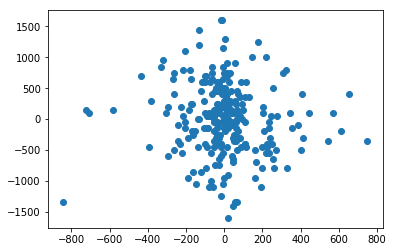

In [206]:
p = plt.scatter(과거비트코인변화, 다음날주가변화)

In [207]:
# cov는 상관관계를 알려준다.
df.cov()

,종가,전일비,시가,고가,저가,거래량,Open*,High,Low,Close**,Volume,Market Cap
종가,6.846078e+06,-1.755498e+04,6.807220e+06,6.780417e+06,6.748902e+06,-1.768174e+09,1.509873e+06,1.509372e+06,1.519761e+06,1.530810e+06,-1.766514e+12,2.530176e+13
전일비,-1.755498e+04,1.984669e+05,-1.146445e+04,2.638181e+04,-4.971497e+04,8.561799e+08,-1.569126e+04,-2.158713e+04,-1.742792e+04,-2.561715e+04,-1.813583e+11,-4.628508e+11
시가,6.807220e+06,-1.146445e+04,7.094596e+06,6.898380e+06,6.874931e+06,-1.543646e+09,1.544614e+06,1.544355e+06,1.547371e+06,1.560183e+06,-1.646136e+12,2.579749e+13
고가,6.780417e+06,2.638181e+04,6.898380e+06,6.845196e+06,6.757650e+06,-1.307755e+09,1.532320e+06,1.531849e+06,1.541699e+06,1.551951e+06,-1.657222e+12,2.567207e+13
저가,6.748902e+06,-4.971497e+04,6.874931e+06,6.757650e+06,6.786465e+06,-1.902252e+09,1.518191e+06,1.521359e+06,1.524395e+06,1.540312e+06,-1.758229e+12,2.544846e+13
거래량,-1.768174e+09,8.561799e+08,-1.543646e+09,-1.307755e+09,-1.902252e+09,1.539529e+13,-6.895658e+08,-7.620610e+08,-6.713624e+08,-7.452021e+08,8.860541e+14,-1.248894e+16
Open*,1.509873e+06,-1.569126e+04,1.544614e+06,1.532320e+06,1.518191e+06,-6.895658e+08,2.294040e+06,2.326722e+06,2.226557e+06,2.271367e+06,1.577697e+12,3.895097e+13
High,1.509372e+06,-2.158713e+04,1.544355e+06,1.531849e+06,1.521359e+06,-7.620610e+08,2.326722e+06,2.380016e+06,2.264298e+06,2.324452e+06,1.850203e+12,3.988235e+13
Low,1.519761e+06,-1.742792e+04,1.547371e+06,1.541699e+06,1.524395e+06,-6.713624e+08,2.226557e+06,2.264298e+06,2.181327e+06,2.226544e+06,1.453797e+12,3.818191e+13
Close**,1.530810e+06,-2.561715e+04,1.560183e+06,1.551951e+06,1.540312e+06,-7.452021e+08,2.271367e+06,2.324452e+06,2.226544e+06,2.287781e+06,1.706507e+12,3.925147e+13


5. 입력X / 출력Y 분리
    - m개의 x, y 쌍
    - X : (m, 60, 10-15) 
        - ridge는 2차원으로만 학습 가능해서 reshape 필요 -> reshape(m, 60*15)
    - Y : (m, 30, 1)

In [208]:
len(df)
input_seq = 60
output_seq = 30
m = len(df) - (input_seq + output_seq) + 1
len(df), m

(244, 155)

In [264]:
# 정규화
#df = df / df.sum()

# min max 정규화
df = (df - df.min()) / (df.max() - df.min())

In [265]:
x_list = []
y_list = []
for i in range(m):
    x = df.iloc[i:i+input_seq]
    y = df.iloc[i+input_seq:i+input_seq+output_seq][['종가', 'Close**']]
    #x.shape, y.shape
    x_list.append(x)
    y_list.append(y)

In [266]:
len(x_list), type(x_list) #(155, 60, 12)
#numpy를 array로 변환
x_3d = np.stack(x_list, axis=0)
y_3d = np.stack(y_list, axis=0)
x_3d.shape, y_3d.shape

((155, 60, 12), (155, 30, 2))

6. 학습용 / 검증용 분리
    - 섞으면 안되므로 직접 분리
    - 가장 오래된 데이터 10%를 검증용으로 사용

In [267]:
test_ratio = 0.1
len(x_3d)
test_m = int(len(x_3d)*test_ratio)
test_m, len(x_2d)-test_m

(15, 140)

In [268]:
m = len(x_3d)
x_2d = np.reshape(x_3d, [m, -1])
y_2d = np.reshape(y_3d, [m, -1])
x_test = x_2d[:test_m]
x_train = x_2d[test_m:]
y_test = y_2d[:test_m]
y_train = y_2d[test_m:]

7. 모델 선정 
    - Ridge 모델기준으로 학습용 데이터로 학습 
    - 성능 측정

In [269]:
from sklearn.linear_model import Ridge, Lasso

In [270]:
rg = Ridge(normalize=True, solver='lsqr').fit(x_train, y_train) # 2차원 이하면 가능해서 에러
#rg = Lasso().fit(x_train, y_train) # 2차원 이하면 가능해서 에러남

In [271]:
rg.score(x_train, y_train)

0.9767361862972054

In [272]:
rg.score(x_test, y_test) #과적합 발생

-14.854996557273719

In [273]:
# 가장 최근 데이터
recent = df.iloc[-input_seq:]
recent.shape #(60, 12)
recent = np.reshape(np.array(recent), [1, -1])
recent.shape #(1, 720)

(1, 720)

In [274]:
p = rg.predict(recent)
p = np.reshape(p, [output_seq, -1])
p.shape

(30, 2)

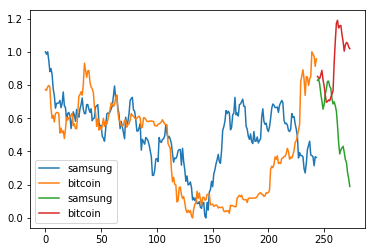

In [279]:
xm = len(df)
plt.plot(np.arange(xm), df['종가'].values, label='samsung')
plt.plot(np.arange(xm), df['Close**'].values, label='bitcoin')
plt.plot(np.arange(xm, xm+output_seq), p[:,0], label='samsung')
plt.plot(np.arange(xm, xm+output_seq), p[:,1], label='bitcoin')
plt.legend()